In [ ]:
import time
import os
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx

from scipy.sparse import csgraph
from numpy import linalg as la
from copy import deepcopy
from sklearn.datasets import fetch_openml
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

Fashion-minist

In [ ]:
def fashion_mnist():
  # fetching data takes time, so do it once
  if not os.path.exists('./datasets'):
    os.mkdir('./datasets')
  if os.path.exists('./datasets/fashion_mnist.npz'):
    print('Fashion-MNIST exists')
    data = np.load('./datasets/fashion_mnist.npz', allow_pickle=True)
    X = data['X']
    y = data['y']
  else:
    print('Downloading fashion_mnist')
    X, y = fetch_openml('Fashion-MNIST', version=1, return_X_y=True, as_frame=False)
    np.savez_compressed('./datasets/fashion_mnist', X=X, y=y)
    print('fashion_mnist downloaded')

  # do binary classifiction
  class0 = '1' #pullover
  class1 = '4' #coat
  X = X[ (y == class0) | (y == class1) ]
  y = y[ (y == class0) | (y == class1) ]
  y[y == class0] = 0
  y[y == class1] = 1

  # random shuffling the dataset
  permutation = np.random.permutation(X.shape[0])
  X = X[permutation]
  y = y[permutation]

  # data scaling
  X = X / np.linalg.norm(X, axis=1)[:, None]
  return X, y

Consider a binary logistic regression model with
$$p(y_i = 1 \mid x) = \frac{\exp(x_i^\top w + b)}{1 + \exp(x_i^\top w + b)},\ p(y_i = 0 \mid x) = 1 - p(y_i=1 \mid x).$$
The loss to minimize is
$$ l(w, b) = \frac{1}{m}\sum_{i=1}^m \Big[-y_i(x_i^\top w + b) + \ln(1 + \exp(x_i^\top w + b)\Big].$$
The gradient for each $w, b$ would be
$$ \frac{1}{m} \sum_{i=1}^m -y_i x_i + \frac{\exp(x_i^\top w + b)}{1 + \exp(x_i^\top w + b)} x_i,  $$
$$ \frac{1}{m} \sum_{i=1}^m -y_i + \frac{\exp(x_i^\top w + b)}{1 + \exp(x_i^\top w + b)}.$$

In [ ]:
# Implement a logistic regression model
class ParallelLogisticRegressionByzantine():
  def __init__(self, X, y, num_agents,
               Byzantine, attack, W=None, W_given=False):
    self.X, self.y, self.X_test, self.y_test = self.train_test(X, y)
    self.w_len = len(self.X[0])
    self.num_agents = num_agents
    self.Byzantine = Byzantine # the set of agents under attacks
    self.num_Byzantine = len(Byzantine)
    self.attack = attack # [0, 1], the proportion of data labels being shuffled.
    self.data_corrupt()
    # initialize weights
    if not W_given:
      self.W = np.random.rand(num_agents, self.w_len)
    else:
      self.W = W

  def train_test(self, X, y):
    X = np.append(X, np.ones([len(X),1]), 1)
    train_idx = np.concatenate((np.argwhere(y == 0)[:6000],
                                np.argwhere(y == 1)[:6000]), axis=0).flatten()
    X_train, y_train = X[train_idx, :], y[train_idx]
    X_test, y_test = np.delete(X, train_idx, axis=0), np.delete(y, train_idx)
    return X_train, y_train, X_test, y_test


  def data_corrupt(self):
    n = len(self.y)
    self.corrupt_labels = np.zeros((self.num_Byzantine, n))
    for i in range(self.num_Byzantine):
      self.corrupt_labels[i] = self.y
      indicies0 = np.argwhere(self.y == 0)
      indicies1 = np.argwhere(self.y == 1)
      num0, num1 = len(indicies0), len(indicies1)
      attack0 = np.random.choice(np.arange(num0), int(num0*self.attack),
                                 replace=False)
      attack1 = np.random.choice(np.arange(num1), int(num0*self.attack),
                                 replace=False)
      attacked_indices = np.concatenate((indicies0[attack0],
                                         indicies1[attack1]))
      self.corrupt_labels[i][attacked_indices] = 1 \
                        - self.corrupt_labels[i][attacked_indices]

  def stochastic_grad(self, batch_size=200):
    grad = np.zeros((self.num_agents, self.w_len))
    byzantine_idx = 0
    for i in range(self.num_agents):
      w = self.W[i]
      n = len(self.y)
      batch = np.random.choice(np.arange(n), batch_size, replace=False)
      X_batch = self.X[batch]
      z = np.exp(X_batch @ w)
      if i in self.Byzantine:
        yi = self.corrupt_labels[byzantine_idx]
        byzantine_idx += 1
      else:
        yi = self.y
      grad[i] = (-yi[batch] + z / (z + 1)) @ self.X[batch] / batch_size
    return grad

  def predict(self):
    acc = np.zeros(self.num_agents)
    for i in range(self.num_agents):
      z = self.X_test @ self.W[i] # no need to compute np.exp
      prediction = np.where(z >= 0, 1, 0)
      acc[i] = 1 - np.linalg.norm(prediction - self.y_test, 1)/len(self.y_test)
    return acc

  def forward(self):
    loss = np.zeros(self.num_agents)
    for i in range(self.num_agents):
      z = self.X @ self.W[i]
      loss[i] = -self.y @ z + np.sum(np.log(1 + np.exp(z)))
      loss[i] = loss[i] / len(self.y)
    return loss

Geometric graph

In [ ]:
# geometric graph
def network_undirected(num_agents, max_distance):
  distance_nodes = np.zeros((num_agents, num_agents))
  connected = False
  while not connected:
      ## each row is the coordinate of a node
      coordinate_nodes = np.random.uniform(0, 1, (num_agents, 2))
      for i in range(num_agents):
          for j in range(num_agents):
              distance_nodes[i][j] \
                  = la.norm(coordinate_nodes[i] - coordinate_nodes[j])
      ## if distance less than max_distance then connect
      network = (distance_nodes <= max_distance) * 1 - np.identity(num_agents)
      if la.matrix_power(network, num_agents - 1).all() > 0:
          connected = True
  return network

Run Fashion-mnist

Fashion-MNIST exists


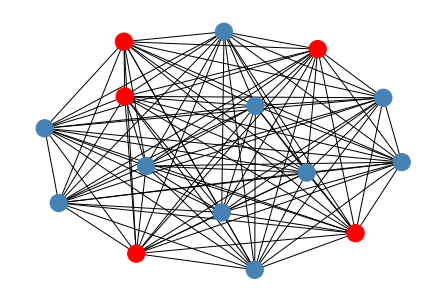

iteration 0:
[0.5 0.5 0.5 0.5 0.5]
acc mean nonByzantine = 0.50
acc mean Byzantine = 0.50
[0.5 0.5 0.5 0.5 0.5]
median acc mean nonByzantine = 0.50
median acc mean Byzantine = 0.50 

iteration 50:
[0.5 0.5 0.5 0.5 0.5]
acc mean nonByzantine = 0.50
acc mean Byzantine = 0.50
[0.5 0.5 0.5 0.5 0.5]
median acc mean nonByzantine = 0.50
median acc mean Byzantine = 0.50 

iteration 100:
[0.622  0.7695 0.674  0.592  0.5215]
acc mean nonByzantine = 0.83
acc mean Byzantine = 0.64
[0.5 0.5 0.5 0.5 0.5]
median acc mean nonByzantine = 0.50
median acc mean Byzantine = 0.50 

iteration 150:
[0.935  0.928  0.932  0.93   0.9155]
acc mean nonByzantine = 0.95
acc mean Byzantine = 0.93
[0.551  0.5335 0.535  0.5405 0.5285]
median acc mean nonByzantine = 0.57
median acc mean Byzantine = 0.54 

iteration 200:
[0.921  0.916  0.9145 0.92   0.904 ]
acc mean nonByzantine = 0.95
acc mean Byzantine = 0.92
[0.8735 0.8625 0.8585 0.8535 0.856 ]
median acc mean nonByzantine = 0.88
median acc mean Byzantine = 0.86 

ite

In [ ]:
if __name__ == '__main__':
  np.random.seed(15213)
  num_agents = 15
  Byzantine = [1, 4, 8, 11, 14]
  dropout = 0.2

  X, y = fashion_mnist()
  plrb = ParallelLogisticRegressionByzantine(X, y, num_agents, Byzantine, 0.6)

  ### Gometric graph
  network = network_undirected(num_agents, 1)
  L = csgraph.laplacian(network)
  nx_graph = nx.from_numpy_array(network)
  color_map = []
  for node in nx_graph:
    if node in Byzantine:
        color_map.append('red')
    else:
        color_map.append('steelblue')
  nx.draw(nx_graph, node_color=color_map)
  plt.savefig('network.pdf', dpi=1200)
  plt.show()

  # parameters
  alpha0, tau1 = 1, 0.9
  beta0, tau2 = 0.1, 0.4

  alpha = lambda t: alpha0 / (t+1)**tau1
  beta = lambda t: beta0 / (t+1)**tau2

  W_med = deepcopy(plrb.W)

  I = np.identity(num_agents)
  accs = np.zeros((30, num_agents))
  test_accs = np.zeros((30, num_agents))
  idx = 0
  for t in range(1500):
    plrb.W -= 0.1 * plrb.stochastic_grad(200)

    # random dropout
    temp = np.random.binomial(1, 1 - dropout, (num_agents, num_agents))
    random_connect = np.triu(temp) + np.triu(temp).T
    random_network = np.multiply(network, random_connect)
    L = csgraph.laplacian(random_network)

    W_med = ( I - beta(t) * L ) @ W_med - alpha(t)*np.sign(W_med - plrb.W)
    if t % 50 == 0:
      ## local optimizers
      acc = plrb.predict()
      accs[idx] = acc
      acc_nonbz_mean = np.mean(np.delete(acc, Byzantine, axis=0))
      acc_bz_mean = np.mean(acc[Byzantine])
      print(f'iteration {t}:')
      print(acc[Byzantine])
      print(f'acc mean nonByzantine = {acc_nonbz_mean:.2f}')
      print(f'acc mean Byzantine = {acc_bz_mean:.2f}')

      ## median trackers
      test = ParallelLogisticRegressionByzantine(X,
                                y, num_agents, Byzantine, 0, W_med, True)
      test_acc = test.predict()
      test_accs[idx] = test_acc
      test_acc_nonbz_mean = np.mean(np.delete(test_acc, Byzantine, axis=0))
      print(test_acc[Byzantine])
      test_acc_bz_mean = np.mean(test_acc[Byzantine])
      print(f'median acc mean nonByzantine = {test_acc_nonbz_mean:.2f}')
      print(f'median acc mean Byzantine = {test_acc_bz_mean:.2f} \n')

      idx += 1
  np.savetxt("accs_6.csv", accs, delimiter=",")
  np.savetxt('testaccs_6.csv', test_accs, delimiter=",")

Plot1

In [ ]:
# iy! sudo apt-get install texlive-latex-recommended
# ! sudo apt-get install dvipng texlive-latex-extra texlive-fonts-recommended
# ! wget http://mirrors.ctan.org/macros/latex/contrib/type1cm.zip
# ! unzip type1cm.zip -d /tmp/type1cm
# ! cd /tmp/type1cm/type1cm/ && sudo latex type1cm.ins
# ! sudo mkdir /usr/share/texmf/tex/latex/type1cm
# ! sudo cp /tmp/type1cm/type1cm/type1cm.sty /usr/share/texmf/tex/latex/type1cm
# ! sudo texhash
# ! apt install cm-super

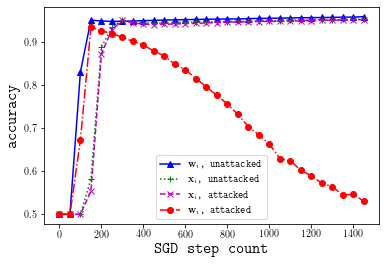

In [ ]:
accs = np.genfromtxt('accs_5.csv', delimiter=",")
testaccs = np.genfromtxt('testaccs_5.csv', delimiter=",")
Byzantine = [1, 4, 8, 11, 14]


acc_bzmean = np.mean(accs[:, Byzantine], axis=1)
acc_nonbz_mean = np.mean(np.delete(accs, Byzantine, axis=1), axis=1)
testacc_bzmean = np.mean(testaccs[:, Byzantine], axis=1)
testacc_nonbz_mean = np.mean(np.delete(testaccs, Byzantine, axis=1), axis=1)

cls = ['b', 'g', 'm', 'r']
linestyles = ['solid', 'dotted', 'dashed', 'dashdot']
markers = ['^', '+', 'x', 'o']
plots = []
plt.clf()
plt.rc('text', usetex=True)
plt.rc('font', family='monospace')
lbs = [r'$\mathbf{w}_i$, unattacked', r'$\mathbf{x}_i$, unattacked',
       r'$\mathbf{x}_i$, attacked', r'$\mathbf{w}_i$, attacked']
accs = [acc_nonbz_mean, testacc_nonbz_mean, testacc_bzmean, acc_bzmean]
for i in range(len(accs)):
  plots.append(plt.plot(np.arange(len(accs[i]))*50, accs[i],
                        c=cls[i], marker=markers[i], linestyle = linestyles[i])[0])
plt.xlabel("SGD step count", fontsize=16)
plt.ylabel("accuracy", fontsize=16)
# plt.title('Average accuracies of $\{\mathbf{x}_i\}$ and $\{\mathbf{w}_i\}$', fontsize=16)
plt.legend(handles=plots, labels=lbs, loc='best')
plt.savefig('accuracies1.pdf', dpi=1200)
plt.show()

Plot2

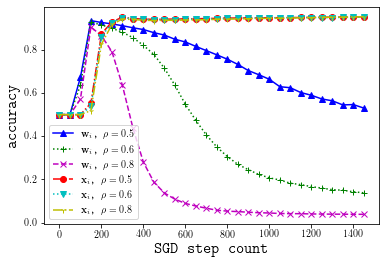

In [ ]:
accs5 = np.genfromtxt('accs_5.csv', delimiter=",")
testaccs5 = np.genfromtxt('testaccs_5.csv', delimiter=",")
accs6 = np.genfromtxt('accs_6.csv', delimiter=",")
testaccs6 = np.genfromtxt('testaccs_6.csv', delimiter=",")
accs8 = np.genfromtxt('accs_8.csv', delimiter=",")
testaccs8 = np.genfromtxt('testaccs_8.csv', delimiter=",")
Byzantine = [1, 4, 8, 11, 14]


acc_bzmean5 = np.mean(accs5[:, Byzantine], axis=1)
acc_bzmean6 = np.mean(accs6[:, Byzantine], axis=1)
acc_bzmean8 = np.mean(accs8[:, Byzantine], axis=1)
testacc_bzmean5 = np.mean(testaccs5[:, Byzantine], axis=1)
testacc_bzmean6 = np.mean(testaccs6[:, Byzantine], axis=1)
testacc_bzmean8 = np.mean(testaccs8[:, Byzantine], axis=1)

cls = ['b', 'g', 'm', 'r', 'c', 'y']
linestyles = ['solid', 'dotted', 'dashed',
              'dashdot', ':', '-.']
markers = ['^', '+', 'x', 'o', 'v', '1']
plots = []
plt.clf()
plt.rc('text', usetex=True)
plt.rc('font', family='monospace')
lbs = [r'$\mathbf{w}_i$, $\rho=0.5$', r'$\mathbf{w}_i$, $\rho=0.6$',
       r'$\mathbf{w}_i$, $\rho=0.8$', r'$\mathbf{x}_i$, $\rho=0.5$',
       r'$\mathbf{x}_i$, $\rho=0.6$', r'$\mathbf{x}_i$, $\rho=0.8$']
accs = [acc_bzmean5, acc_bzmean6, acc_bzmean8,
        testacc_bzmean5, testacc_bzmean6, testacc_bzmean8]
for i in range(len(accs)):
  plots.append(plt.plot(np.arange(len(accs[i]))*50, accs[i],
                        c=cls[i], marker=markers[i], linestyle = linestyles[i])[0])
plt.xlabel("SGD step count", fontsize=16)
plt.ylabel("accuracy", fontsize=16)
# plt.title('Average accuracies of $\{\mathbf{x}_i\}$ and $\{\mathbf{w}_i\}$', fontsize=16)
plt.legend(handles=plots, labels=lbs, loc='best')
plt.savefig('accuracies2.pdf', dpi=1200)
plt.show()